# title



In [3]:
%reset
# import dependencies
import os
import librosa
import librosa.display
import matplotlib
from matplotlib import pyplot as plt
import sys
import numpy as np
from numpy import matlib
import scipy.signal

# tell jupyter notebook to show the plots inline
%matplotlib inline

# define and add paths
dir_beg = '/home/kendra/Documents/sakata-rotation/birdsong-patterns'
dir_data = dir_beg + '/data/audio_for_visualization_notebook'
dir_function = dir_beg + '/src'
sys.path.append('./src')

# get function
os.chdir(dir_function)
from pcen_snr import detect_activity

# get list of audio files
os.chdir(dir_data) # need to be in the directory to load the file with librosa
audio_list = os.listdir() 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
# load audio
naudio = 6
file_name = audio_list[naudio]
y,sr = librosa.load(file_name)
#librosa.display.waveplot(y,sr=sr, x_axis='time')

In [8]:
# set parameters
n_mels=128
fmin=1000
fmax=11025
hop_length=512
gain=0.8
bias=10
power=0.25
pcen_time_constant=0.06
eps=1e-06
medfilt_time_constant=1
normalized=False
peak_threshold=2
activity_threshold=0.2

In [9]:
# apply pcen-snr
[begs, ends] = detect_activity(y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, 
        hop_length=hop_length, gain=gain, bias=bias, power=power, 
        pcen_time_constant=pcen_time_constant, eps=eps,
        medfilt_time_constant=medfilt_time_constant, normalized=normalized, 
        peak_threshold=peak_threshold, activity_threshold=activity_threshold)

(0, 10)

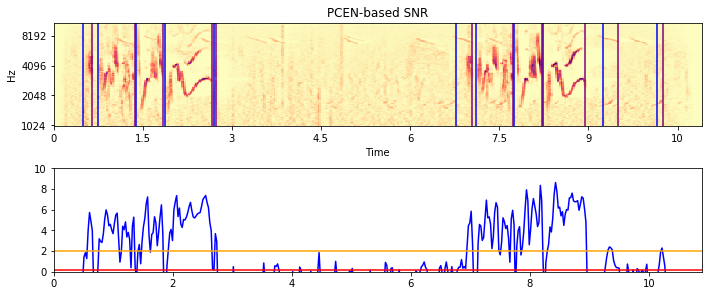

In [7]:
# visualize

# Compute mel-frequency spectrogram
melspec = librosa.feature.melspectrogram(y, sr=sr, fmin=fmin, fmax=fmax, 
    hop_length=hop_length, n_mels=n_mels)
    
# Compute per-channel energy normalization (PCEN-SNR)
pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
    power=power, hop_length=hop_length,
    time_constant=pcen_time_constant, eps=eps)

# compute PCEN-SNR detection function
pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
if normalized:
    pcen_snr = pcen_snr / np.max(pcen_snr)

# apply median filtering.
if medfilt_time_constant is not None:
    medfilt_hops = medfilt_time_constant * sr / hop_length
    kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
    pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
    
# plot PCEN spectrogram
times = np.linspace(0, len(y)/sr, num=melspec.shape[1])
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
librosa.display.specshow(pcen, sr=sr,fmin=fmin, fmax=fmax,
    x_axis='time', y_axis='mel', cmap='magma_r')
for b in begs:
    plt.axvline(b, color='blue')
for e in ends:
    plt.axvline(e, color='purple')
plt.title('PCEN-based SNR')
plt.tight_layout()

# plot median-filtered pcen-snr detection function along with the peak and activity thresholds
peak_thresh_plt = np.matlib.repmat(peak_threshold,times.size,1)
activity_thresh_plt = np.matlib.repmat(activity_threshold,times.size,1)
plt.subplot(3, 1, 2)
plt.plot(times, pcen_snr, color="blue")
plt.plot(times, peak_thresh_plt, color='orange')
plt.plot(times, activity_thresh_plt, color='red')
plt.xlim(times[0], times[-1])
plt.ylim(0, 10)    

